### So this notebook is the code to find the centroid shift over time for a brown dwarf.

I use Lu et al. (2018) to find the centroid shift equation. The equation requires the Einstein radius, which requires the mass of the lens, so we need to do something about that. 

So, I made the y-axis the centroid shift of a star mass of 5 Mjup. All the mass does is provide magnitude to the centroid shift. Later on we can confirm the shift is greater than our astrometric precision.

In [530]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

from astropy.io import ascii
from PyAstronomy import pyasl

import seaborn as sns
from matplotlib import rcParams

rcParams.update({'font.size': 25})

In [599]:
#importing the brown dwarfs in
candidate_stars = ascii.read('apjsaaf6aft4_ascii.txt', format='tab')
candidate_stars.keep_columns(['(1)', '(2)', '(4)', '(6)', '(8)', '(9)'])

candidate_stars.rename_column('(1)', 'object_name')
candidate_stars.rename_column('(2)', 'J2000_ra')
candidate_stars.rename_column('(4)', 'J2000_dec')
candidate_stars.rename_column('(6)', 'pi_abs')
candidate_stars.rename_column('(8)', 'mu_ra')
candidate_stars.rename_column('(9)', 'mu_dec')

#keep rows with stars with nearby ephemerides
#needs copy to preserve length of table in for loop
candidate_stars_2 = candidate_stars.copy()
#need different list because .index() cannot do masked columns -- adds lots of unfortunate complexity
candidate_stars_2_o = list(candidate_stars_2['object_name'])
for i in candidate_stars['object_name']:
    if i != 'WISE 0855-0714' and i != 'WISE 0952+1955':
        obj_index = candidate_stars_2_o.index(i)
        candidate_stars_2.remove_row(obj_index)
        candidate_stars_2_o.remove(i)
candidate_stars = candidate_stars_2
        
#importing the path lists in and keeping to 2022
path_list_0855 = pd.read_csv('0855-0714_path.csv')
#path_list_0855 = path_list_0855.head(37)

path_list_0952 = pd.read_csv('0952+1955_path.csv')
#path_list_0952 = path_list_0952.head(37)

#importing the stars in
filename_a = '0855-0714_eph.txt'
filename_a_cut = filename_a[:9]

filename_b = '0952+1955_eph.txt'
filename_b_cut = filename_b[:9]

full_filename_a = 'C:\\Users\\judah\\candidate_stars_ephemerides\\' + filename_a
full_filename_b = 'C:\\Users\\judah\\candidate_stars_ephemerides\\' + filename_b

#get background star data and filter to ones that concern us
background_star_a = pd.read_csv(full_filename_a)
background_star_a = background_star_a[background_star_a['decals_id'].isin([7696600349215571, 7696600349215541])]

background_star_b = pd.read_csv(full_filename_b)
background_star_b = background_star_b[background_star_b['decals_id'].isin([7696610489926820])]

#combine both tables
background_star = pd.concat([background_star_a, background_star_b])

### Now for the funky stuff:
I want to run through the brown dwarf path, check the centroid shift at each point, and plot it. I also want to add in a delta_ml colorbar for ease.

In [590]:
##
# check the einstein radius (almost -- look at comment above e_r) for a given dwarf, background star, and separation
##
def einstein_radius(star_data):
    point = 0
    parallax = star_data['pi_abs']
    for i in range(len(parallax)):
        if parallax[i] == ' ':
            point = i
            break
    parallax = float(parallax[:point]) / 1000 #convert from mas to arcseconds      

    #basic constants
    big_g = 4.3 * math.pow(10, -3) #pc * solar_mass^-1 * (km/s)^2
    c_squared = (9 * math.pow(10, 10)) #(km/s)^2
    
    #calculate eintstein radius / (mass of lens)^(1/2) in mas/(solar masses)^(1/2)
    e_r = np.sqrt(4 * 0.01432 * big_g * (1 / c_squared) * parallax) * 206265 * 1000
    
    return e_r

In [591]:
##
# calculate and return an array of time, mas / (mass of lens)^(1/2)
##
def centroid_shift(einstein_radius, path_list, background_star):
    shift_list = list()

    for i in range(len(path_list)):
        theta = pyasl.getAngDist(path_list['RA'][i], path_list['Dec'][i], float(background_star['ra']), float(background_star['dec']))

        #convert from radians to arcseconds
        theta *= (2 * np.pi * (1 / 360)) * 206264

        shift = (einstein_radius * theta) / ((theta ** 2) + 2)
        
        shift_list.append((path_list['Time'][i], shift))
        
    return shift_list

In [600]:
#compute einstein radii and centroid shift plots for all
er_0855 = einstein_radius(candidate_stars[0])
er_0952 = einstein_radius(candidate_stars[1])

shift_0855_a = centroid_shift(er_0855, path_list_0855, background_star.iloc[[0]])
shift_0855_a = pd.DataFrame(shift_0855_a, columns=['Time', 'Shift'])

shift_0855_b = centroid_shift(er_0855, path_list_0855, background_star.iloc[[1]])
shift_0855_b = pd.DataFrame(shift_0855_b, columns=['Time', 'Shift'])

shift_0952 = centroid_shift(er_0952, path_list_0952, background_star.iloc[[2]])
shift_0952 = pd.DataFrame(shift_0952, columns=['Time', 'Shift'])

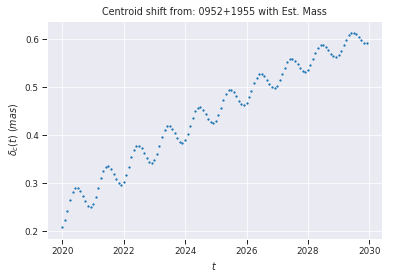

In [601]:
#plot the three plots
with sns.axes_style('darkgrid', {'xtick.bottom': True, 'ytick.left': True}):
    sns.set_context('paper')
    
    plt.title('Centroid shift from: ' + filename_b_cut + ' with Est. Mass')
    plt.xlabel(r'$ t $')
    plt.ylabel(r'$ \delta_{c}(t) \ (mas) $')
    
    shift_plot = plt.scatter(shift_0952['Time'], shift_0952['Shift'], s= 2)
    
    #plt.savefig(r'C:\\Users\\judah\\centroid_shift\\' + '0952_centroidshift_mass')

In [373]:
#make a delta_ml colorbar through the path as well?